In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
import pickle
import json

from GPy import models
import GPy

import sobol
import optunity

import torch
import torch.optim as optim
from torch.nn import CrossEntropyLoss, Conv2d, Sequential, BatchNorm2d
from torch.utils.data import DataLoader

import torchvision
import torchvision.datasets as datasets
from torchvision import transforms

from util import train_NN, test_loss, loadCIFAR10, plot_GPmodel
from HyperparamOptimizer import HyperparamOptimizer

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


In [3]:
batch_size = 100

train_dataset, train_dataloader, test_dataset, test_dataloader, classes = loadCIFAR10(batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
from Models import LeNet

parameter_range = {"lr": [0.0, 0.5], "momentum": [
    0.5, 1], "p_randomTransform": [0, 1]}


def train_function(parameters, device):
    epochs = 2
    input_shape = (batch_size, 3, 32, 32)
    num_labels = 10
    criterion = CrossEntropyLoss()

    model = LeNet(input_shape, num_labels,
                  initial_lr=parameters["lr"], momentum=parameters["momentum"], weight_decay=0).to(device)
    train_NN(model, criterion, train_dataloader,
             test_dataloader, epochs=epochs, batches_to_test=1000, patience=2, device=device,
             print_test=False, verbose=False, p_randomTransform=parameters["p_randomTransform"])
    return test_loss(model, train_dataloader, criterion, device)[1]


LeNet_optim = HyperparamOptimizer(
    train_function=train_function, parameter_range=parameter_range, device=device)

In [5]:
num_samples = 3
num_iterations = 3

LeNet_optim.get_sobol_samples(num_samples)
LeNet_optim.GPR_optim(num_iterations)

In [ ]:
with open('models/LeNet_Cifar/LeNet_optimizer.pkl', 'wb') as file:
    pickle.dump(LeNet_optim, file)

In [ ]:
with open('models/LeNet_Cifar/LeNet_optimizer.pkl', 'rb') as file:
    LeNet_optim = pickle.load(file)

In [ ]:
print(LeNet_optim.values)
print(LeNet_optim.points)
print(LeNet_optim.gp_predictions)

[[ 9.796]
 [49.16 ]
 [47.844]
 [47.206]
 [45.94 ]
 [46.016]]
[[0.         0.5        0.        ]
 [0.25       0.75       0.5       ]
 [0.375      0.625      0.75      ]
 [0.31416347 0.79095003 0.73878431]
 [0.02096435 0.56266346 0.98213377]
 [0.25553397 0.79558541 0.81549893]]
[        nan         nan         nan 29.91564816 28.81332384 37.37176141]


In [ ]:
print(LeNet_optim.get_best_parameters())

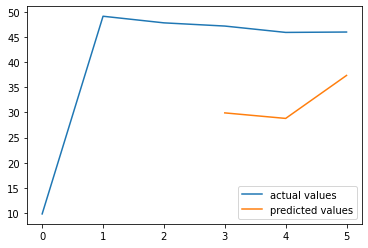

In [16]:
plt.plot(LeNet_optim.values, label = 'actual values')
plt.plot(LeNet_optim.gp_predictions, label = 'predicted values')
plt.legend()
plt.show()

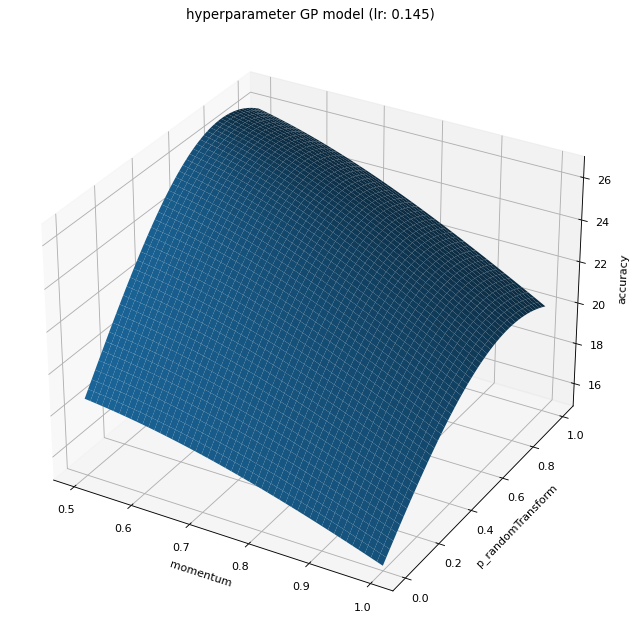

In [17]:
plot_GPmodel(LeNet_optim, "momentum", "p_randomTransform", "lr", 0.145)

In [4]:
parameter_range = {"lr": [0.0, 0.5], "momentum": [0.5, 1], "p_randomTransform": [0, 1]}
num_params = len(parameter_range.keys())

In [6]:
from Models import LeNet
criterion = CrossEntropyLoss()
input_shape = (batch_size, 3, 32, 32)
epochs = 4

def train_mnist(parameters):
    test_device = "cpu"
    model = LeNet(input_shape, 10, initial_lr=parameters["lr"], momentum=parameters["momentum"], weight_decay=0).to(test_device)
    train_NN(model, criterion, train_dataloader,
    test_dataloader, epochs=epochs, batches_to_test=1000,patience=2,device=test_device, print_test=False, verbose=False, p_randomTransform=parameters["p_randomTransform"])
    return test_loss(model, train_dataloader, criterion, test_device)[1]

In [7]:
number_of_samples = 5

parameterUpperLimits = np.array([parameter_range[i][1] for i in parameter_range])
parameterLowerLimits = np.array([parameter_range[i][0] for i in parameter_range])

values = np.zeros(number_of_samples)
points = np.zeros((number_of_samples, num_params))

for i in range(number_of_samples):
    paramters = {}
    parameter_list = sobol.i4_sobol(num_params,i)[0] * (parameterUpperLimits - parameterLowerLimits) + parameterLowerLimits
    for j, param in enumerate(parameter_range):
        paramters[param] = parameter_list[j]
    values[i] = train_mnist(paramters)
    points[i] = np.array(parameter_list)

values = values[:,None]

In [8]:
def GPPredict(lr, momentum, p_randomTransform):
    return gpmodel.predict_noiseless(np.array([[lr, momentum, p_randomTransform]]))[0]

In [9]:
def maxVarGP(lr, momentum, p_randomTransform):
    return gpmodel.predict_noiseless(np.array([[lr,momentum, p_randomTransform]]))[1]

In [26]:
iterations = 15
gp_prediction = []

for i in range(iterations):
    gpmodel = models.GPRegression(points, values,GPy.kern.Matern52(num_params, ARD = True))

    if i%2 == 0 or i >= 30:
        pars, details, _  = optunity.maximize(GPPredict, lr = [0.0, 0.5], momentum = [0.5,1], p_randomTransform = [0.0, 1.0])
    else:
        pars, details, _  = optunity.maximize(maxVarGP, lr = [0.0, 0.5], momentum = [0.5,1], p_randomTransform = [0.0, 1.0])


    q = np.array([pars['lr'], pars['momentum'], pars["p_randomTransform"]])
    value = train_mnist(pars)

    gp_prediction.append(GPPredict(q[0], q[1], q[2])[0][0])
    
    points = np.append(points, [q], axis = 0)
    values = np.append(values, [[value]], axis = 0)


In [28]:
with open('models/LeNet_Cifar/LeNet_GPmodel.pkl', 'wb') as file:
    pickle.dump(gpmodel, file)

In [30]:
with open('models/LeNet_Cifar/LeNet_GPmodel.pkl', 'rb') as file:
    gpmodel = pickle.load(file)

In [31]:
i = np.argmax(values)
hyperparameter_stats = {"values" : values.tolist(), "points": points.tolist(), "gp_prediction": gp_prediction, "best": {"acc": values[i][0], "params": points[i].tolist()}}
with open('models/LeNet_Cifar/LeNet_parameter.json', 'w') as file:
    json.dump(hyperparameter_stats, file, ensure_ascii=False, indent=4)

In [32]:
with open('models/LeNet_Cifar/LeNet_parameter.json', 'rb') as file:
    hyperparameter_stats = json.load(file)

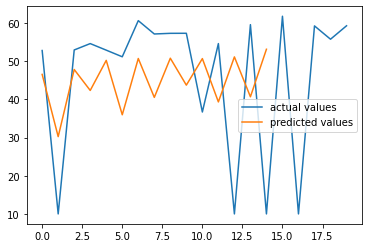

In [33]:
plt.plot(values[number_of_samples:], label = 'actual values')
plt.plot(np.array(gp_prediction), label = 'predicted values')
plt.legend()
plt.show()

In [34]:
print(values)
print(points)
print(gp_prediction)

[[10.4  ]
 [54.18 ]
 [53.006]
 [56.082]
 [56.332]
 [52.796]
 [10.   ]
 [52.942]
 [54.612]
 [52.892]
 [51.158]
 [60.62 ]
 [57.128]
 [57.298]
 [57.312]
 [36.694]
 [54.612]
 [10.   ]
 [59.572]
 [10.   ]
 [61.774]
 [10.   ]
 [59.242]
 [55.756]
 [59.276]]
[[0.00000000e+00 5.00000000e-01 0.00000000e+00]
 [2.50000000e-01 7.50000000e-01 5.00000000e-01]
 [3.75000000e-01 6.25000000e-01 7.50000000e-01]
 [1.25000000e-01 8.75000000e-01 2.50000000e-01]
 [1.87500000e-01 6.87500000e-01 6.25000000e-01]
 [2.75917969e-01 7.71035156e-01 5.98136264e-01]
 [4.39040898e-01 8.92717602e-01 1.27309521e-02]
 [2.36870526e-01 7.97719989e-01 7.08023477e-01]
 [4.84482160e-01 5.48613281e-01 2.10546875e-02]
 [3.15322266e-01 6.90341005e-01 6.62324219e-01]
 [2.92960675e-01 7.70644598e-01 7.05996094e-01]
 [2.06676465e-02 7.54501953e-01 3.52484234e-04]
 [1.94049337e-01 6.82092024e-01 5.61445312e-01]
 [5.25657328e-02 6.60370536e-01 9.96732876e-01]
 [1.93359375e-01 7.12292028e-01 6.90156250e-01]
 [4.88496094e-01 7.84394531e-

In [35]:
lr, momentum, p_randomTransformi = np.argmax(values)
lr, momentum ,p_randomTansform = points[i]
print(f"acc: {values[i][0]}")
print(f"lr: {lr}, momentum: {momentum}, p_randomTransform: {p_randomTansform}")

TypeError: cannot unpack non-iterable numpy.int64 object

In [59]:
def plot_GPmodel_____(gpmodel, parameter_range, axis_1, axis_2, axis_3, axis_3_value, elevation = 30, azim = -60):
    fig = plt.figure(figsize = (10,10), dpi = 80)
    ax = fig.add_subplot(111, projection='3d')

    x = np.arange(parameter_range[axis_1][0], parameter_range[axis_1][1], 0.0005)
    y = np.arange(parameter_range[axis_2][0], parameter_range[axis_2][1], 0.0005)
    X, Y = np.meshgrid(x, y)

    xflat = X.flatten()
    yflat = Y.flatten()
    z = np.ones_like(xflat) * axis_3_value
    p = np.array([xflat, yflat, z])

    zs = np.array(gpmodel.predict_noiseless(p.T)[0])
    Z = zs.reshape(X.shape)

    surf = ax.plot_surface(X, Y, Z)

    ax.set_xlabel(axis_1)
    ax.set_ylabel(axis_2)
    ax.set_zlabel('accuracy')

    ax.set_title(f'hyperparameter GP model ({axis_3}: {axis_3_value})')

    ax.view_init(elevation, azim)

    plt.show()

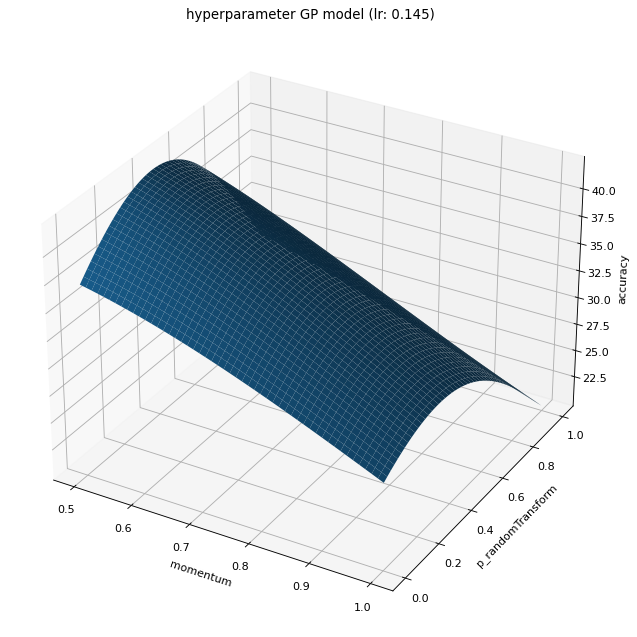

In [60]:
plot_GPmodel(gpmodel, parameter_range, "momentum", "p_randomTransform", "lr", 0.145)

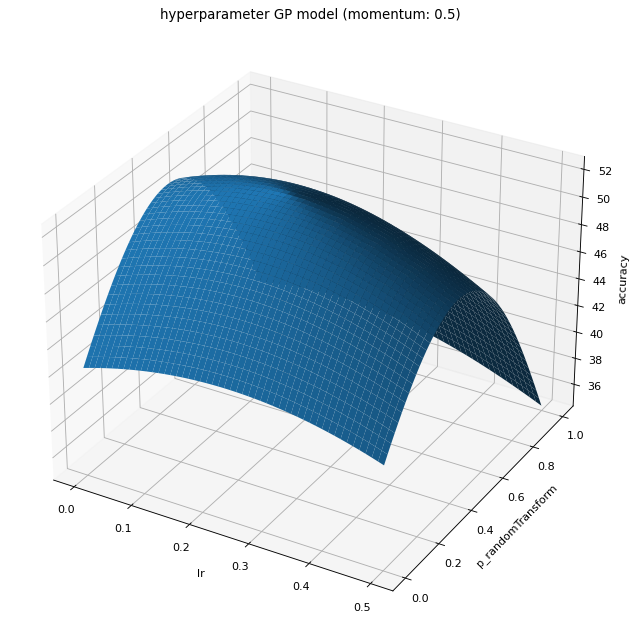

In [40]:
plot_GPmodel(gpmodel, parameter_range, "lr", "p_randomTransform", "momentum", 0.5)

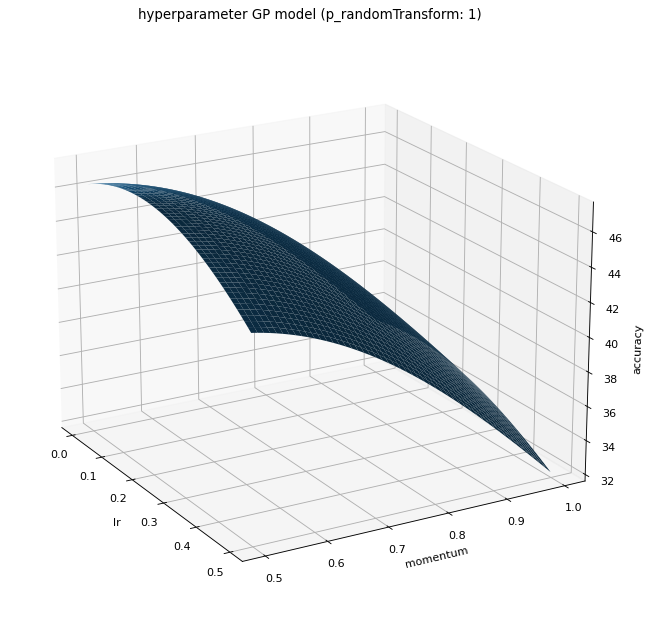

In [62]:
plot_GPmodel(gpmodel, parameter_range, "lr", "momentum", "p_randomTransform", 1, azim=-30, elevation=20)